## ***Evaluation***

In [36]:
#importing the libraries
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments,DataCollatorForSeq2Seq
import evaluate
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
#test data loading
test_path = "/content/drive/MyDrive/MScDissertation-Sonu/data/processed/test_processed.csv"
df_test = pd.read_csv(test_path)
test_text_dataset = Dataset.from_pandas(df_test[['input_text','target_text']])



In [28]:
#defining evaluation funcitons....
rouge = evaluate.load('rouge')
bertscore = evaluate.load('bertscore')

def evaluate_model(model_path, processed_text_dataset):
    print(f"evaluating model from: {model_path}")

    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    def preprocess_function(examples):
        return tokenizer(text=examples["input_text"],text_target=examples["target_text"],max_length=512,truncation=True)


    tokenized_test = processed_text_dataset.map(preprocess_function, batched=True, remove_columns=["input_text", "target_text"])

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    dummy_args = Seq2SeqTrainingArguments(output_dir="./temp_eval", per_device_eval_batch_size=16, predict_with_generate=True,remove_unused_columns=False,)
    trainer = Seq2SeqTrainer(model=model, args=dummy_args, data_collator=data_collator)

    print("running predictions...")
    predictions = trainer.predict(tokenized_test)

    decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
    decoded_labels = processed_text_dataset["target_text"]

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bert_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    bert_result = {"bert_score_f1": np.mean(bert_result['f1']) * 100}
    result = {**rouge_result, **bert_result}
    final_scores = {k: round(v, 4) for k, v in result.items()}

    print(f"Evaluation complete for {model_path}")
    return final_scores, decoded_preds

In [29]:
model_paths = {"BART-large": "/content/drive/MyDrive/MScDissertation-Sonu/models/bart-large-final",
    "T5-large": "/content/drive/MyDrive/MScDissertation-Sonu/models/t5-large-final",
    "PEGASUS-xsum": "/content/drive/MyDrive/MScDissertation-Sonu/models/pegasus-xsum-final",}

all_results = {}
all_predictions = {}
for name, path in model_paths.items():
    scores, preds = evaluate_model(path,test_text_dataset)
    if scores:
        all_results[name] = scores
        all_predictions[name] = preds

evaluating model from: /content/drive/MyDrive/MScDissertation-Sonu/models/bart-large-final


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

running predictions...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sonikaysannakki16 (sonikaysannakki16-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation complete for /content/drive/MyDrive/MScDissertation-Sonu/models/bart-large-final
evaluating model from: /content/drive/MyDrive/MScDissertation-Sonu/models/t5-large-final


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

running predictions...


Evaluation complete for /content/drive/MyDrive/MScDissertation-Sonu/models/t5-large-final
evaluating model from: /content/drive/MyDrive/MScDissertation-Sonu/models/pegasus-xsum-final


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

running predictions...


Evaluation complete for /content/drive/MyDrive/MScDissertation-Sonu/models/pegasus-xsum-final


In [30]:

df_test.dropna(subset=['target_text', 'llm_generated_summary'], inplace=True)

decoded_preds_llm = df_test['llm_generated_summary'].tolist()
decoded_labels_llm = df_test['target_text'].tolist()

rouge_result_llm = rouge.compute(predictions=decoded_preds_llm, references=decoded_labels_llm)
bert_result_llm = bertscore.compute(predictions=decoded_preds_llm, references=decoded_labels_llm, lang="en")
bert_result_llm = {"bert_score_f1": np.mean(bert_result_llm['f1']) * 100}

llm_scores = {**rouge_result_llm, **bert_result_llm}
all_results["Flan-T5-XL (Zero-Shot)"] = {k: round(v, 4) for k, v in llm_scores.items()}
all_predictions["Flan-T5-XL (Zero-Shot)"] = decoded_preds_llm
print("evaluation complete for Zero-Shot LLM")

evaluation complete for Zero-Shot LLM


In [40]:
results_df = pd.DataFrame(all_results).T

for col in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']:
    if col in results_df.columns:
        results_df[col] = results_df[col] * 100
display(results_df.style.highlight_max(color='green', axis=0).format("{:.2f}"))

,rouge1,rouge2,rougeL,rougeLsum,bert_score_f1
BART-large,30.05,14.77,27.66,27.82,88.43
T5-large,29.51,12.88,27.38,27.33,88.47
PEGASUS-xsum,32.61,15.30,28.19,28.29,88.62
Flan-T5-XL (Zero-Shot),18.43,5.34,15.75,15.68,87.14


In [41]:
raw_test_df = pd.read_csv("/content/drive/MyDrive/MScDissertation-Sonu/data/processed/test_processed.csv")
final_comparison_df = raw_test_df.copy()

for model_name, preds in all_predictions.items():
    final_comparison_df[f"{model_name}_prediction"] = preds

final_comparison_df.to_csv("/content/drive/MyDrive/MScDissertation-Sonu/results/final_predictions_comparison.csv", index=False)
print("All model predictions have been saved to 'final_predictions_comparison.csv'")

All model predictions have been saved to 'final_predictions_comparison.csv'


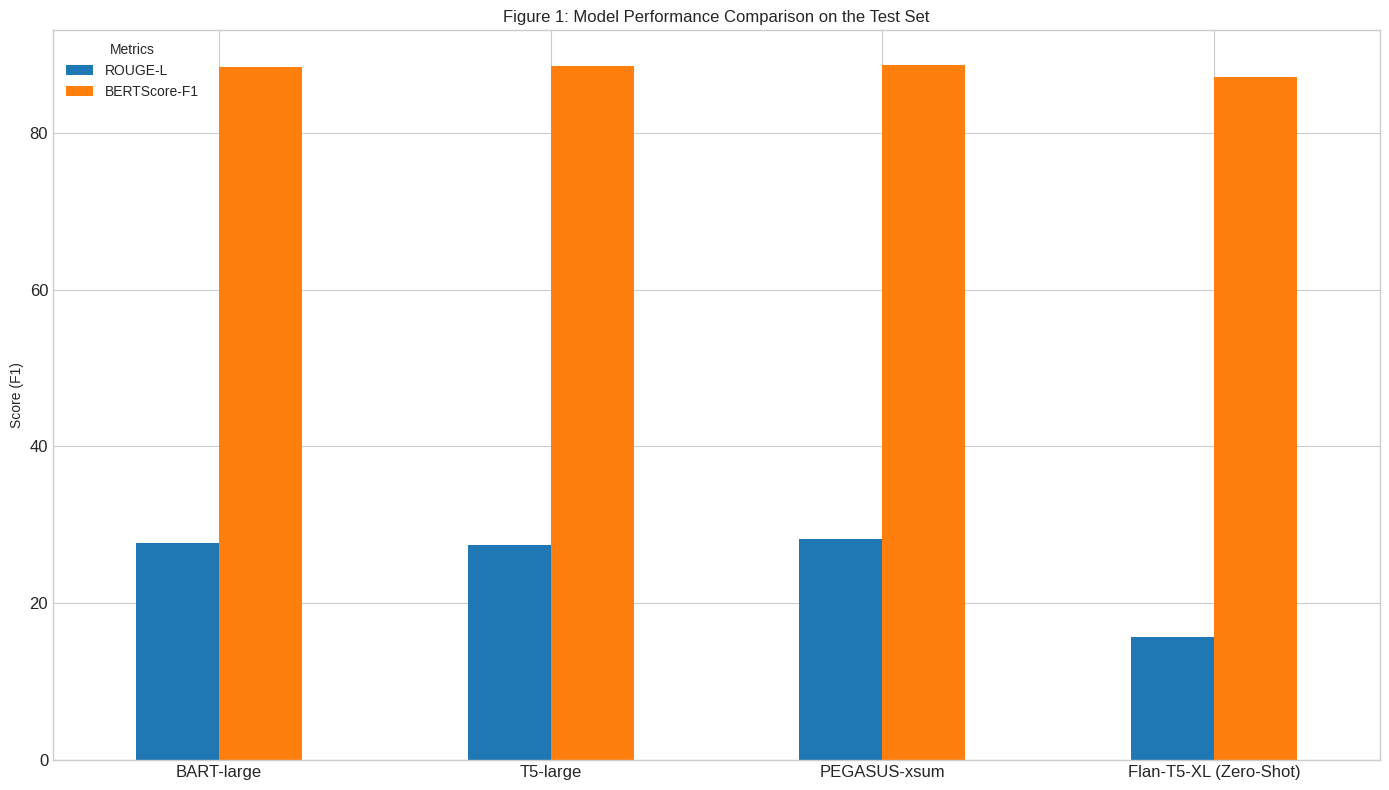

In [42]:
plt.style.use('seaborn-v0_8-whitegrid')
results_to_plot = results_df[['rougeL', 'bert_score_f1']].copy()
results_to_plot.rename(columns={'rougeL': 'ROUGE-L', 'bert_score_f1': 'BERTScore-F1'}, inplace=True)

results_to_plot.plot(kind='bar',figsize=(14, 8),rot=0,title="Figure 1: Model Performance Comparison on the Test Set",fontsize=12)
plt.ylabel("Score (F1)")
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()
